In [1]:
# Suppress Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
from tools import Data
from collections import Counter
import time
import sklearn
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Processing the data

In [2]:
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
print(categories)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [3]:
categories_short = ['atheism','graphics','win misc','win hard','mac hard','win x','forsale','auto','motocycles','baseball','hockey','crypt','elct','med','space','christian','guns','mideast','politics misc','religion misc']

In [4]:
# Takes ~4 minutes
start = time.time()
data = Data(categories)
print(time.time() - start)

Calculating Vocabulary...
Loading Testing Data...
Loading Training Data...
Normalizing training Data...
Splitting Training Data into Training and Validation...
126.96352505683899


In [5]:
print('Top 10 words in the vocab: %s' % (', '.join(map(str, data.vocab[:10]))))

Top 10 words in the vocab: the, to, of, a, and, i, in, is, that, it


## Comparing Data Representation Methods with Logistic Regression

In [6]:
model_bin = LogisticRegression()
model_bin.fit(data.train_bin, data.train_bin_labels)
bin_acc = 100.0 * model_bin.score(data.valid_bin, data.valid_bin_labels)
print('Binary input representation accuracy:  %.2f%%' % bin_acc)

Binary input representation accuracy:  86.90%


In [7]:
model_max = LogisticRegression()
model_max.fit(data.train_max, data.train_max_labels)
max_acc = 100.0 * model_max.score(data.valid_max, data.valid_max_labels)
print('Max input representation accuracy: %.2f%%' % max_acc)

Max input representation accuracy: 84.60%


In [8]:
model_log = LogisticRegression()
model_log.fit(data.train_log, data.train_log_labels)
log_acc = 100.0 * model_log.score(data.valid_log, data.valid_log_labels)
print('Log input representation accuracy: %.2f%%' % log_acc)

Log input representation accuracy: 87.96%


In [9]:
best_model = model_log

## Tuning Hyperparameters

In [10]:
Cs = np.random.uniform(0.01, 6, (20,1))
l_ratio = np.random.uniform(0,1,(20,1))

rand_search_acc = []

# Do 20 random searches for Hyperparameters (with very small iterations)
for k in range(20):
    print(f'Fitting Model no. {k+1}/20...')
    
    rand_search_mod = LogisticRegression(C=float(Cs[k]), penalty='elasticnet', l1_ratio=float(l_ratio[k]), solver='saga', max_iter=10)
    rand_search_mod.fit(data.train_log, data.train_log_labels)
    
    acc = 100 * rand_search_mod.score(data.valid_log, data.valid_log_labels)
    rand_search_acc.append(acc)
    print(f'    C={Cs[k]};    l_ratio={l_ratio[k]};    accuracy={rand_search_acc[k]}')

Fitting Model no. 1/20...
    C=[5.80324545];    l_ratio=[0.95428952];    accuracy=82.30088495575221
Fitting Model no. 2/20...
    C=[2.15096753];    l_ratio=[0.85278244];    accuracy=82.7433628318584
Fitting Model no. 3/20...
    C=[5.65498401];    l_ratio=[0.05526234];    accuracy=82.0353982300885
Fitting Model no. 4/20...
    C=[2.88409857];    l_ratio=[0.71786856];    accuracy=82.56637168141593
Fitting Model no. 5/20...
    C=[3.64962727];    l_ratio=[0.95757522];    accuracy=82.30088495575221
Fitting Model no. 6/20...
    C=[1.92918327];    l_ratio=[0.46399866];    accuracy=82.47787610619469
Fitting Model no. 7/20...
    C=[5.45409785];    l_ratio=[0.7786398];    accuracy=81.94690265486726
Fitting Model no. 8/20...
    C=[3.51433784];    l_ratio=[0.34374997];    accuracy=82.38938053097345
Fitting Model no. 9/20...
    C=[5.38965585];    l_ratio=[0.8531815];    accuracy=82.0353982300885
Fitting Model no. 10/20...
    C=[2.90801246];    l_ratio=[0.09977056];    accuracy=82.212389380

Best Regularization: [2.15096753]
Best L Ratio: [0.85278244]


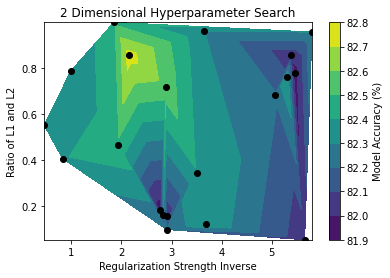

In [19]:
plt.tricontourf(np.squeeze(Cs),np.squeeze(l_ratio),np.array(rand_search_acc))
plt.xlabel('Regularization Strength Inverse')
plt.ylabel('Ratio of L1 and L2')
cbar = plt.colorbar()
cbar.set_label('Model Accuracy (%)')
plt.title('2 Dimensional Hyperparameter Search')
plt.plot(np.squeeze(Cs), np.squeeze(l_ratio), 'ko ')

best_C = Cs[np.argmax(np.array(rand_search_acc))]
best_lratio = l_ratio[np.argmax(np.array(rand_search_acc))]
print(f'Best Regularization: {best_C}')
print(f'Best L Ratio: {best_lratio}')

In [12]:
# Train Model With Best Parametecrs
best_model = LogisticRegression(C=float(best_C), penalty='elasticnet', l1_ratio=float(best_lratio), solver='saga',max_iter=150)
best_model.fit(data.train_log, data.train_log_labels)

LogisticRegression(C=2.1509675332058285, l1_ratio=0.8527824369199526,
                   max_iter=150, penalty='elasticnet', solver='saga')

## Evaluate the best model

In [13]:
best_acc = 100.0 * best_model.score(data.test_log, data.test_labels)
print('Best model accuracy: %.2f%%' % best_acc)

Best model accuracy: 81.36%


In [14]:
pred = best_model.predict(data.test_log)
confusion = metrics.confusion_matrix(data.test_labels, pred)

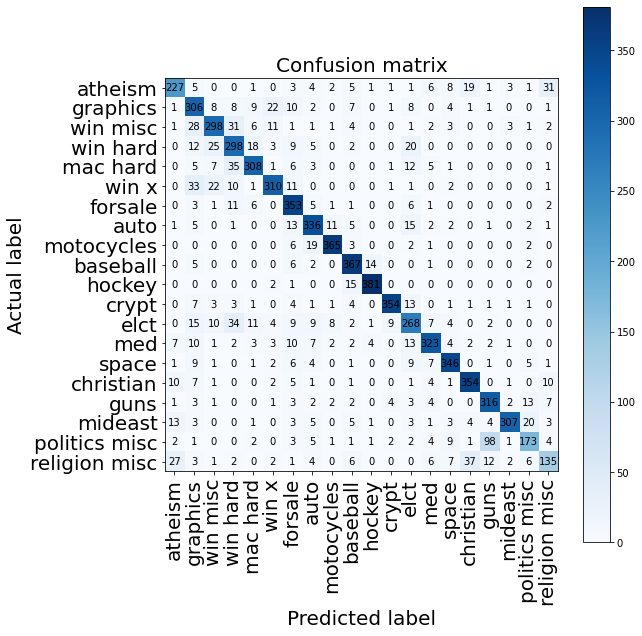

In [15]:
plt.figure(figsize=(9,9))
plt.imshow(confusion, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix', size = 20)
plt.colorbar()
tick_marks = np.arange(20)
plt.xticks(tick_marks, categories_short, size = 20, rotation=90)
plt.yticks(tick_marks, categories_short, size = 20)
plt.tight_layout()
plt.ylabel('Actual label', size = 20)
plt.xlabel('Predicted label', size = 20)
width, height = confusion.shape
for x in range(width):
    for y in range(height):
        plt.annotate(confusion[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center')

In [16]:
misses = np.array([sum(line) - line[cat] for cat, line in enumerate(confusion)])
top_five = [categories[cat] for cat in misses.argsort()[-5::]]

# electronics, MS windows, computer graphics and PC hardware are very similar topics
# so it is understandable that the model confuses those 4 the most
print('Top 5 misclassified labels from worst to best: %s' % top_five)

Top 5 misclassified labels from worst to best: ['comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'talk.religion.misc', 'sci.electronics', 'talk.politics.misc']


## Model Inspection of the best model

In [17]:
for cat, features in enumerate(best_model.coef_):
    top_ten = [data.vocab[word] for word in features.argsort()[-10::]]
    bottom_ten = [data.vocab[word] for word in features.argsort()[:10]]
    print('Highest features for %s: %s' % (categories[cat], ', '.join(map(str, top_ten))))
    print('Lowest features for %s: %s' % (categories[cat], ', '.join(map(str, bottom_ten))))
    print()

Highest features for alt.atheism: thoughts, rushdie, islamic, mozumder, mathew, umd, atheism, benedikt, keith, atheists
Lowest features for alt.atheism: thanks, mail, interested, rutgers, ca, help, internet, wondering, phone, use

Highest features for comp.graphics: surface, sphere, cview, polygon, animation, images, image, tiff, pov, graphics
Lowest features for comp.graphics: re, sale, my, list, drive, writes, who, mike, people, s

Highest features for comp.os.ms-windows.misc: nt, ini, file, drivers, microsoft, dos, driver, win, cica, windows
Lowest features for comp.os.ms-windows.misc: of, sale, re, stack, r, replies, mac, they, apple, he

Highest features for comp.sys.ibm.pc.hardware: drive, dos, controller, monitor, monitors, ide, card, dx, gateway, pc
Lowest features for comp.sys.ibm.pc.hardware: re, writes, in, mac, latest, apple, article, sun, we, macintosh

Highest features for comp.sys.mac.hardware: adb, lc, se, iisi, duo, quadra, powerbook, centris, apple, mac
Lowest feature

# TODO List
- code TODO:
    + \[step b\] \[kind of optional\] implement the more complex vocabulary
- report TODO:
    + \[step b \] table of top 10 words
    + \[step b\] mutual information of the top 10 words?? what is mutual information? the fact that they are all filler words??
        * Do we have to calculate I from part (b)?
    + \[step e\] Comment on whether the top 5 misclassified labels make sense given the topics.
    + \[step f\] Compare the results to what you found using mutual information.